In [1]:
import numpy as np, pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import  (roc_auc_score, average_precision_score, f1_score, accuracy_score,
    precision_score, recall_score, classification_report, roc_curve, precision_recall_curve, confusion_matrix)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from scipy.stats import randint, uniform, loguniform

In [2]:
data = pd.read_csv("./data/users_prep.csv")
data = data.drop("Unnamed: 0", axis=1) 
data = data.dropna()

In [3]:
all_cols = data.columns.tolist()
first14_cols = all_cols[:32] + all_cols[-1:]
data = data[first14_cols].copy()

In [4]:
data.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,...,W_avg_median_amount,W_avg_count_transaction,M_avg_min_amount,M_avg_max_amount,M_avg_mean_amount,M_avg_median_amount,M_avg_count_transaction,M_evg_unique_merchants,M_median_gap_sec,fraud_risk
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,29278,...,71.547335,22.130350,2.589153,559.207627,80.417801,68.428941,96.398305,32.644068,18420.0,0.0
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,37891,...,64.614815,10.881323,2.200085,686.285932,79.696503,66.091822,47.398305,28.025424,37530.0,1.0
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,22681,...,31.666401,50.365759,0.978983,412.923729,33.051507,32.344788,219.389831,36.983051,7380.0,1.0
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,163145,...,61.903687,16.889105,5.520763,1576.102458,125.770742,58.425551,73.567797,33.559322,20040.0,0.0
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,53797,...,87.131060,17.951362,4.826525,817.697966,96.408370,87.651398,78.194915,36.466102,20160.0,0.0


In [5]:
X = data.drop(columns=['id', 'fraud_count', 'fraud_risk', 'birth_month', 'longitude', 'latitude',
                       'W_avg_min_amount', 'W_avg_max_amount', 'W_avg_mean_amount', 'address', 
                       'W_avg_median_amount', 'W_avg_count_transaction'])
y = data['fraud_risk']

In [6]:
cat_cols = X.select_dtypes(include=["object","category"]).columns.tolist()
num_cols = X.columns.difference(cat_cols).tolist()

preprocess = ColumnTransformer([("num", StandardScaler(), num_cols),
                                ("cat", OneHotEncoder(handle_unknown="ignore", sparse=False), cat_cols)])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

### Logistic / RF / GB / SVM / KNN / XGBoost / LGBM 

In [8]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=5000, class_weight="balanced", 
                                             solver="lbfgs", random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=500, class_weight="balanced", 
                                           n_jobs=-1, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "SVM_RBF": SVC(kernel="rbf", probability=True, class_weight="balanced", C=1.0, 
                   gamma="scale", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=15, weights="distance"),
    "XGBoost": XGBClassifier(n_estimators=1000, max_depth=10, learning_rate=0.05, subsample=0.8, 
                             colsample_bytree=0.8, objective="binary:logistic", 
                             eval_metric="logloss", n_jobs=-1, random_state=42),
    "LGBM": LGBMClassifier(n_estimators=1000, num_leaves=63, learning_rate=0.05, subsample=0.8, 
                           colsample_bytree=0.8, class_weight="balanced", n_jobs=-1, random_state=42)
    }

#### 학습 결과

In [9]:
pipes = {}  

for name, clf in models.items():
    pipe = Pipeline([("prep", preprocess), ("clf", clf)])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    pipes[name] = pipe  

    print("\n", "="*20, f"{name}", "="*20)
    print(classification_report(y_test, pred, digits=4))


 ==================== LogisticRegression ====================
              precision    recall  f1-score   support

         0.0     0.7009    0.5616    0.6236       146
         1.0     0.4961    0.6429    0.5600        98

    accuracy                         0.5943       244
   macro avg     0.5985    0.6023    0.5918       244
weighted avg     0.6186    0.5943    0.5980       244


 ==================== RandomForest ====================
              precision    recall  f1-score   support

         0.0     0.6343    0.7603    0.6916       146
         1.0     0.4928    0.3469    0.4072        98

    accuracy                         0.5943       244
   macro avg     0.5635    0.5536    0.5494       244
weighted avg     0.5774    0.5943    0.5774       244


 ==================== GradientBoosting ====================
              precision    recall  f1-score   support

         0.0     0.6748    0.7534    0.7120       146
         1.0     0.5556    0.4592    0.5028        98

 

#### 중요도가 큰 피처

- table / 수평 막대 그래프 : 각 모델마다 중요도가 큰 상위 20개 피처
  - feature: 전처리(One-Hot 포함) 이후의 실제 피처 이름
  - importance: 모델이 판단한 상대적 중요도 값
- RandomForest / GradientBoosting / XGBoost / LGBM
  - feature_importances_를 사용(보통 분기/손실 감소 기여도)
  - 값이 클수록 그 피처가 결정나무 분할에서 더 자주, 더 크게 성능 향상에 기여했다는 뜻
- LogisticRegression
  - |coef_|(계수의 절댓값)을 중요도로 사용
  - coef_signed가 양수면 사기일 확률을 올리는 방향, 음수면 내리는 방향. 크기가 클수록 영향 큼
- SVM_RBF / KNN
  - 고유 중요도가 없어서 Permutation importance로 근사(스코어는 average_precision)
  - 해당 피처를 랜덤 섞었을 때 PR-AUC가 얼마나 떨어지는지의 평균 기여를 수치화


=== LogisticRegression — Feature Importance ===


,feature,importance,coef_signed
0,num__num_credit_cards,0.498153,0.498153
1,cat__least_prefer_Chip,0.482173,-0.482173
2,cat__least_prefer_Swipe,0.481406,0.481406
3,cat__most_prefer_Chip,0.460032,-0.460032
4,cat__most_prefer_Swipe,0.378028,0.378028
5,num__birth_year,0.361541,-0.361541
6,num__per_capita_income,0.239489,-0.239489
7,num__M_avg_median_amount,0.192162,-0.192162
8,num__current_age,0.167292,-0.167292
9,num__M_avg_max_amount,0.149803,0.149803


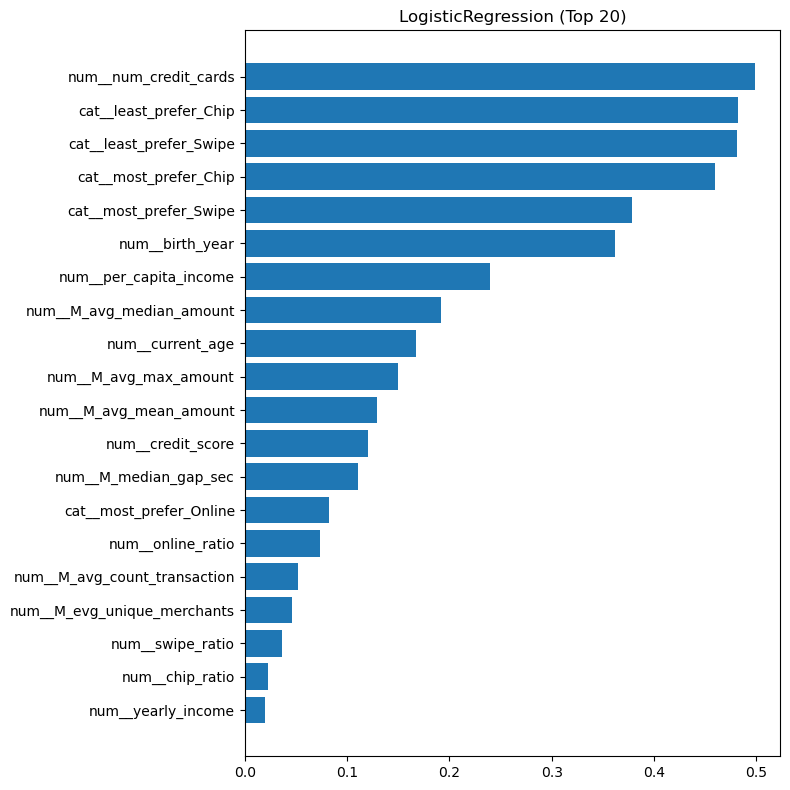


=== RandomForest — Feature Importance ===


,feature,importance
0,num__M_evg_unique_merchants,0.067431
1,num__birth_year,0.059441
2,num__current_age,0.057294
3,num__M_avg_max_amount,0.056679
4,num__M_median_gap_sec,0.056207
5,num__chip_ratio,0.056185
6,num__num_credit_cards,0.055801
7,num__M_avg_median_amount,0.055615
8,num__M_avg_count_transaction,0.054422
9,num__total_debt,0.053185


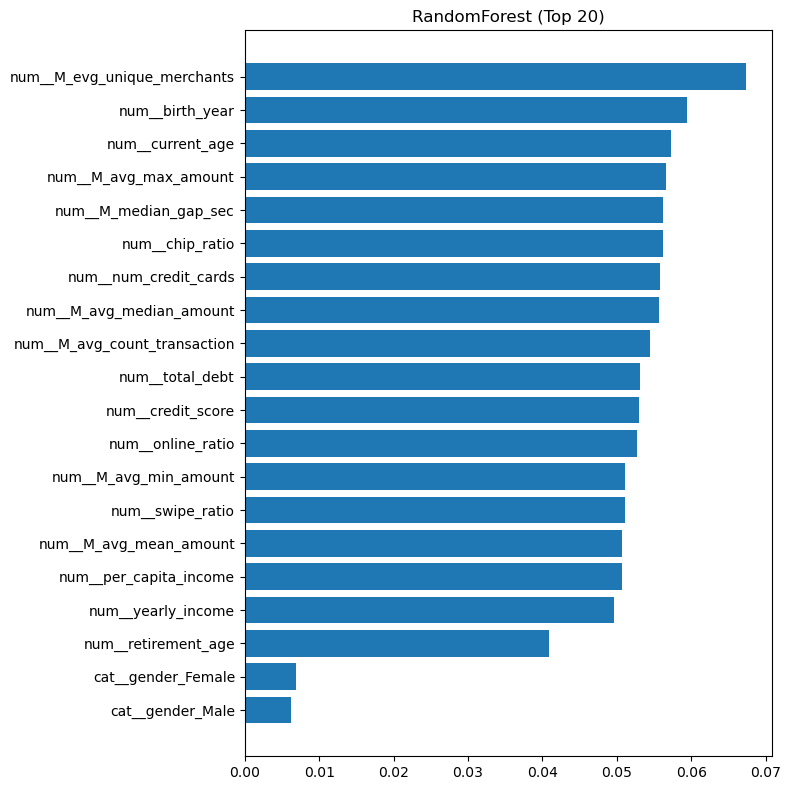


=== GradientBoosting — Feature Importance ===


,feature,importance
0,num__num_credit_cards,0.132533
1,num__M_evg_unique_merchants,0.104795
2,num__M_avg_count_transaction,0.072087
3,num__M_avg_max_amount,0.065774
4,num__birth_year,0.063588
5,num__per_capita_income,0.057399
6,num__M_median_gap_sec,0.055953
7,num__M_avg_median_amount,0.052666
8,num__swipe_ratio,0.051931
9,num__chip_ratio,0.049683


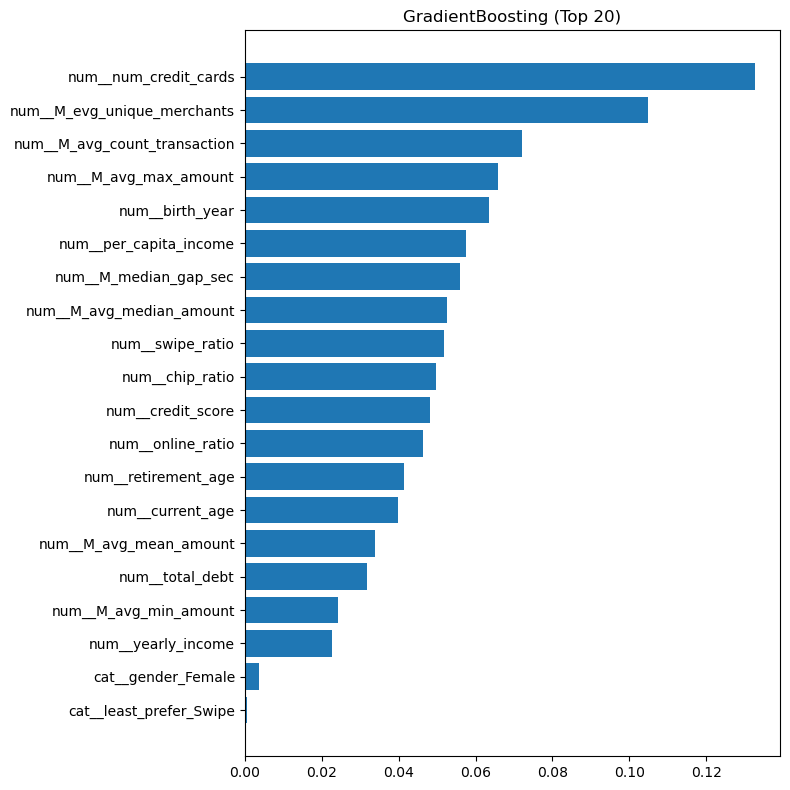


=== SVM_RBF — Feature Importance ===


,feature,importance
0,num__chip_ratio,0.062931
1,num__M_median_gap_sec,0.007228
2,num__M_avg_count_transaction,0.002351
3,cat__gender_Male,0.001862
4,num__M_avg_mean_amount,0.001615
5,num__online_ratio,0.001359
6,cat__gender_Female,0.000225
7,cat__most_prefer_Chip,0.000157
8,num__total_debt,0.000032
9,cat__least_prefer_Online,0.000000


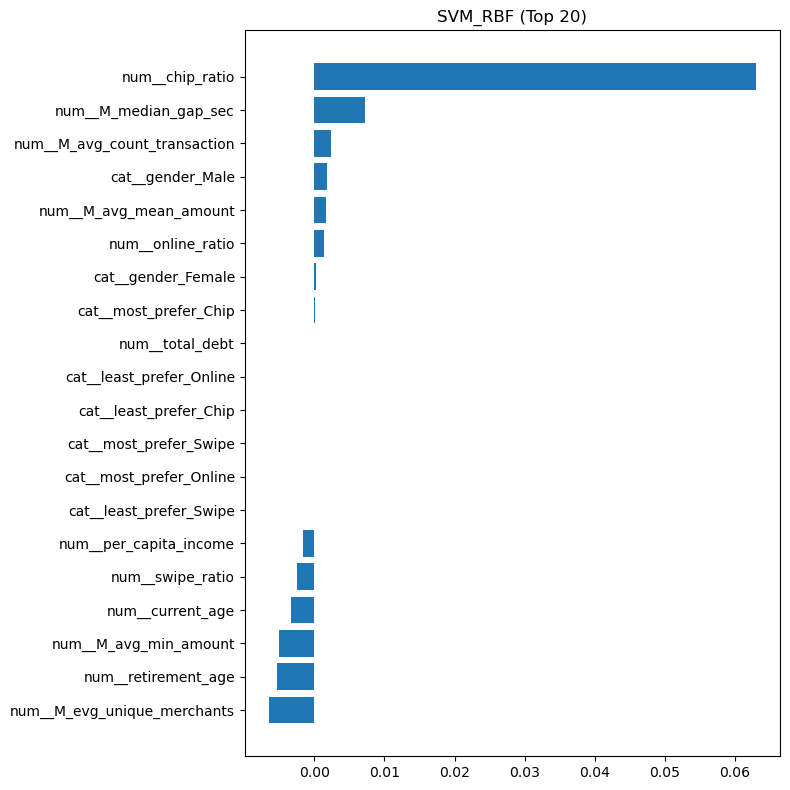


=== KNN — Feature Importance ===


,feature,importance
0,num__chip_ratio,0.048169
1,num__M_avg_median_amount,0.011951
2,cat__gender_Male,0.010344
3,num__M_avg_count_transaction,0.008654
4,num__M_avg_mean_amount,0.006479
5,num__online_ratio,0.005532
6,cat__gender_Female,0.001437
7,num__retirement_age,0.001179
8,num__total_debt,0.000546
9,cat__least_prefer_Online,0.000000


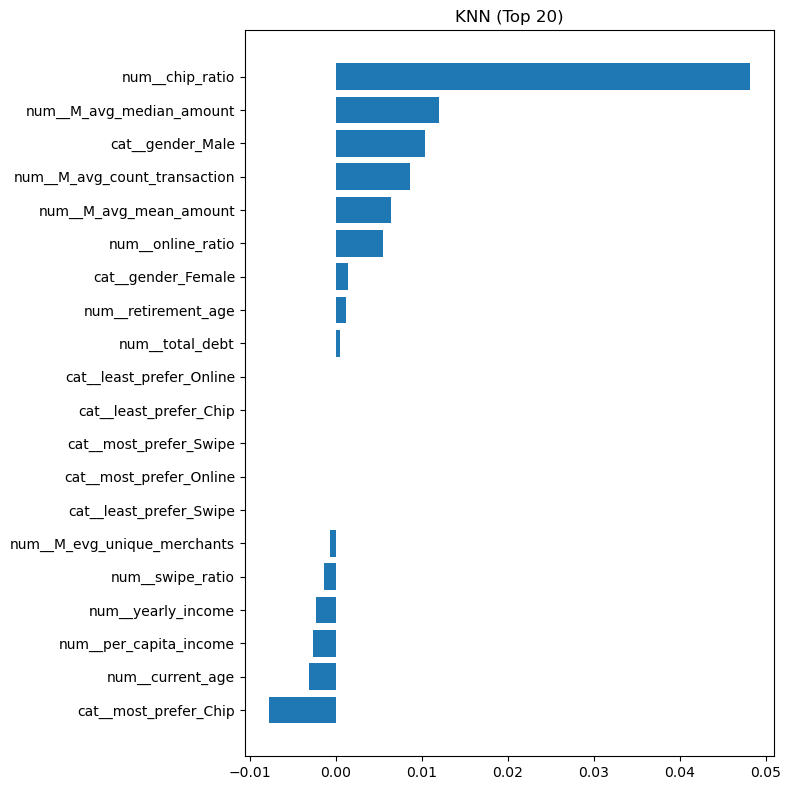


=== XGBoost — Feature Importance ===


,feature,importance
0,cat__most_prefer_Chip,0.135359
1,cat__most_prefer_Swipe,0.093624
2,num__num_credit_cards,0.069872
3,cat__least_prefer_Online,0.048339
4,num__birth_year,0.044941
5,num__M_evg_unique_merchants,0.039826
6,num__current_age,0.038930
7,num__M_avg_count_transaction,0.035718
8,num__per_capita_income,0.035220
9,num__M_avg_max_amount,0.033474


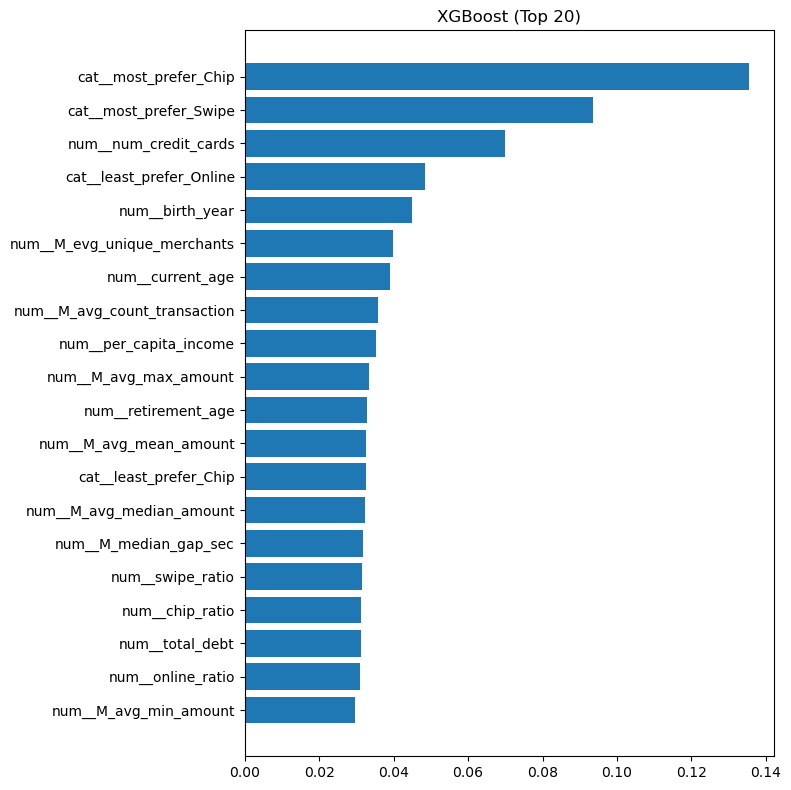


=== LGBM — Feature Importance ===


,feature,importance
0,num__chip_ratio,2704.0
1,num__credit_score,2473.0
2,num__M_evg_unique_merchants,2423.0
3,num__online_ratio,2413.0
4,num__M_avg_max_amount,2293.0
5,num__total_debt,2268.0
6,num__M_median_gap_sec,2265.0
7,num__M_avg_median_amount,2185.0
8,num__M_avg_min_amount,2182.0
9,num__M_avg_count_transaction,1952.0


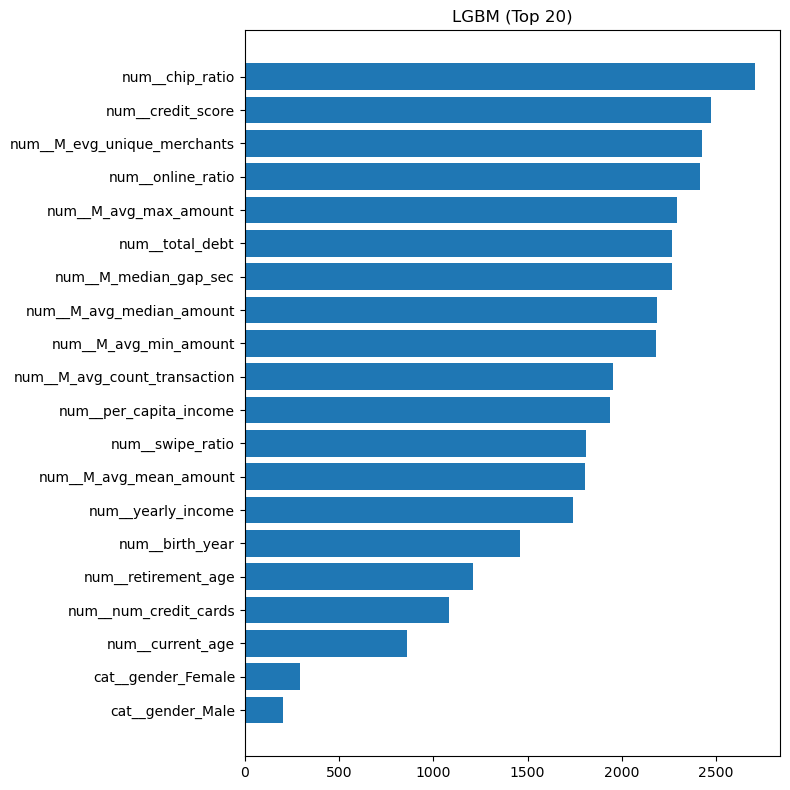

In [10]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from scipy import sparse

def _is_fitted_ct(ct):
    return hasattr(ct, "transformers_")

def _to_dense_shape(Xt):
    if sparse.issparse(Xt):
        return Xt.shape[1]
    return Xt.shape[1]

def safe_feature_names(pipe, X_train):
    prep = pipe.named_steps.get("prep", None)
    if prep is None:
        return np.array(list(X_train.columns)), len(X_train.columns)
    if not _is_fitted_ct(prep):
        prep.fit(X_train)

    Xt_sample = prep.transform(X_train.iloc[:5])
    n_after = _to_dense_shape(Xt_sample)

    # 1) get_feature_names_out 시도
    try:
        fn = prep.get_feature_names_out(X_train.columns)
        fn = np.asarray(fn, dtype=object)
        if len(fn) == n_after:
            return fn, n_after
    except Exception:
        pass

    # 2) 서브 변환기에서 끌어오기 (가능하면)
    try:
        names = []
        for name, trans, cols in prep.transformers_:
            if name == "remainder" and trans == "drop":
                continue
            if trans == "passthrough":
                # 선택된 컬럼명이 문자열이면 그대로, 인덱스면 X_train에서 매핑
                if isinstance(cols[0], (str, np.str_)):
                    names.extend(list(cols))
                else:
                    names.extend(list(X_train.columns[cols]))
            else:
                # 원-핫 등: 하위 변환기가 get_feature_names_out 지원하면 사용
                if hasattr(trans, "get_feature_names_out"):
                    base = cols if isinstance(cols, (list, np.ndarray, pd.Index)) else np.array(cols)
                    # base가 인덱스(정수)면 실제 컬럼명으로 바꿔줌
                    if len(base) > 0 and isinstance(base[0], (int, np.integer)):
                        base = np.array(list(X_train.columns[base]))
                    sub_names = trans.get_feature_names_out(base)
                    names.extend(list(sub_names))
                else:
                    # 이름을 만들 수 없으면 개수만 맞춤
                    Xt_part = trans.transform(X_train[cols]) if isinstance(cols[0], str) else trans.transform(X_train.iloc[:, cols])
                    names.extend([f"{name}__f{i}" for i in range(_to_dense_shape(Xt_part))])
        names = np.asarray(names, dtype=object)
        if len(names) == n_after:
            return names, n_after
    except Exception:
        pass

    # 3) 최종 안전 장치: 개수만 맞춰 f0..f{n-1}
    return np.array([f"f{i}" for i in range(n_after)], dtype=object), n_after

def show_topk(df_imp, title, topk=20):
    if df_imp is None or df_imp.empty:
        print(f"[WARN] {title}: 중요도 계산 불가")
        return
    df_top = df_imp.sort_values("importance", ascending=False).head(topk)
    display(df_top.reset_index(drop=True))
    plt.figure(figsize=(8, max(4, 0.4*len(df_top))))
    plt.barh(df_top.iloc[::-1]["feature"], df_top.iloc[::-1]["importance"])
    plt.title(title)
    plt.tight_layout()
    plt.show()

def importance_df_from_pipe(name, pipe, X_train, y_train, X_test, y_test):
    clf = pipe.named_steps["clf"]
    fn, n_after = safe_feature_names(pipe, X_train)

    # 트리/부스팅 계열
    if hasattr(clf, "feature_importances_") and clf.feature_importances_ is not None:
        vals = np.asarray(clf.feature_importances_, dtype=float)
        # 길이 불일치 시 보정
        if len(vals) != n_after:
            # 차이가 나면 앞쪽/뒤쪽 패딩 or 트렁케이션(최소한 DataFrame 에러는 방지)
            if len(vals) < n_after:
                vals = np.pad(vals, (0, n_after - len(vals)))
            else:
                vals = vals[:n_after]
        return pd.DataFrame({"feature": fn, "importance": vals})

    # 로지스틱
    from sklearn.linear_model import LogisticRegression
    if isinstance(clf, LogisticRegression) and hasattr(clf, "coef_"):
        coefs = np.ravel(clf.coef_)
        if len(coefs) != n_after:
            if len(coefs) < n_after:
                coefs = np.pad(coefs, (0, n_after - len(coefs)))
            else:
                coefs = coefs[:n_after]
        return pd.DataFrame({
            "feature": fn, 
            "importance": np.abs(coefs),
            "coef_signed": coefs
        })

    # 그 외(SVM_RBF, KNN 등): permutation importance (테스트셋 기준, PR-AUC)
    r = permutation_importance(pipe, X_test, y_test, scoring="average_precision",
                               n_repeats=7, random_state=42, n_jobs=-1)
    vals = r.importances_mean
    if len(vals) != n_after:
        if len(vals) < n_after:
            vals = np.pad(vals, (0, n_after - len(vals)))
        else:
            vals = vals[:n_after]
    return pd.DataFrame({"feature": fn, "importance": vals})

# === 실행: 각 모델 즉시 표시 ===
for name, pipe in pipes.items():
    print(f"\n=== {name} — Feature Importance ===")
    try:
        imp_df = importance_df_from_pipe(name, pipe, X_train, y_train, X_test, y_test)
        show_topk(imp_df, f"{name} (Top 20)")
    except Exception as e:
        print(f"[ERROR] {name}: {e}")


### 하이퍼파라미터 튜닝 

In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [12]:
models = {
    "LogisticRegression": (LogisticRegression(max_iter=5000, class_weight="balanced", 
                                              solver="lbfgs", random_state=42),
                          {"clf__C": loguniform(1e-2, 1e2)}, 25),
    
    "RandomForest": (RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=42),
                    {"clf__n_estimators": randint(500, 1500),
                     "clf__max_depth": randint(3, 30),
                     "clf__min_samples_split": randint(2, 20),
                     "clf__min_samples_leaf": randint(1, 10),
                     "clf__max_features": ["sqrt", "log2", None]}, 35),
                     
    "GradientBoosting": (GradientBoostingClassifier(random_state=42),
                        {"clf__n_estimators": randint(300, 1200),
                         "clf__learning_rate": loguniform(0.01, 0.3),
                         "clf__max_depth": randint(2, 6),
                         "clf__subsample": uniform(0.6, 0.4),
                         "clf__min_samples_leaf": randint(1, 20)}, 35),
    
    "SVM_RBF": (SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42),
               {"clf__C": loguniform(1e-2, 1e3),
                "clf__gamma": loguniform(1e-4, 1e-1)}, 30),
    
    "KNN": (KNeighborsClassifier(),
            {"clf__n_neighbors": randint(3, 61),
             "clf__weights": ["uniform", "distance"],
             "clf__p": [1, 2]}, 30),

    "XGBoost": (XGBClassifier(objective="binary:logistic", eval_metric="aucpr", n_jobs=-1, 
                              tree_method="hist", random_state=42),
               {"clf__n_estimators": randint(400, 1500),
                "clf__max_depth": randint(3, 8),
                "clf__learning_rate": loguniform(0.01, 0.2),
                "clf__subsample": uniform(0.6, 0.4),
                "clf__colsample_bytree": uniform(0.5, 0.5),
                "clf__min_child_weight": randint(1, 10),
                "clf__gamma": uniform(0.0, 5.0),
                "clf__reg_alpha": loguniform(1e-8, 1e-1),
                "clf__reg_lambda": loguniform(1e-3, 10.0)}, 40),
    
    "LGBM": (LGBMClassifier(objective="binary", class_weight="balanced", n_jobs=-1, random_state=42),
            {"clf__n_estimators": randint(600, 2000),
             "clf__num_leaves": randint(31, 255),
             "clf__learning_rate": loguniform(0.02, 0.2),
             "clf__min_child_samples": randint(10, 120),
             "clf__subsample": uniform(0.6, 0.4),
             "clf__colsample_bytree": uniform(0.5, 0.5),
             "clf__reg_lambda": loguniform(1e-3, 10.0),
             "clf__reg_alpha": loguniform(1e-8, 1e-1)}, 40)
    }

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 35 candidates, totalling 175 fits
Fitting 5 folds for each of 35 candidates, totalling 175 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


,model,best_params,cv_AP,test_acc,test_prec,test_rec,test_f1@0.5,test_ROC_AUC,test_PR_AUC
0,LogisticRegression,{'clf__C': 0.012087541473056955},0.559197,0.614754,0.516129,0.653061,0.576577,0.638594,0.526558
1,SVM_RBF,"{'clf__C': 26.373339933815252, 'clf__gamma': 0...",0.567576,0.573770,0.477273,0.642857,0.547826,0.616019,0.524972
2,XGBoost,"{'clf__colsample_bytree': 0.6516327573366114, ...",0.572322,0.594262,0.494118,0.428571,0.459016,0.607842,0.491366
3,GradientBoosting,"{'clf__learning_rate': 0.025166071275502962, '...",0.574992,0.614754,0.524390,0.438776,0.477778,0.603928,0.483767
4,RandomForest,"{'clf__max_depth': 28, 'clf__max_features': No...",0.581278,0.594262,0.495238,0.530612,0.512315,0.615110,0.477515
5,LGBM,"{'clf__colsample_bytree': 0.5597971229691509, ...",0.541571,0.577869,0.471910,0.428571,0.449198,0.580514,0.461476
6,KNN,"{'clf__n_neighbors': 49, 'clf__p': 1, 'clf__we...",0.537583,0.586066,0.478261,0.336735,0.395210,0.547526,0.435976


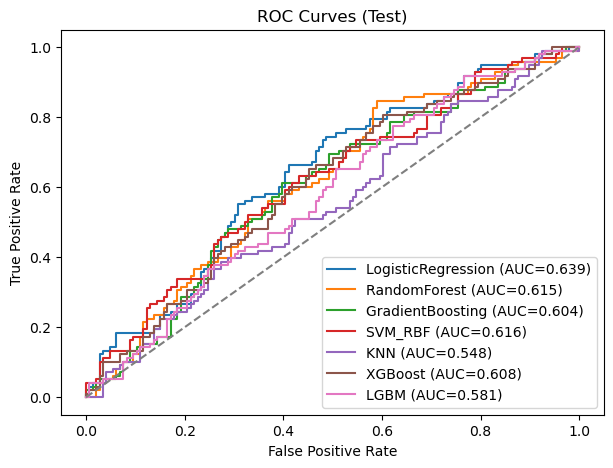

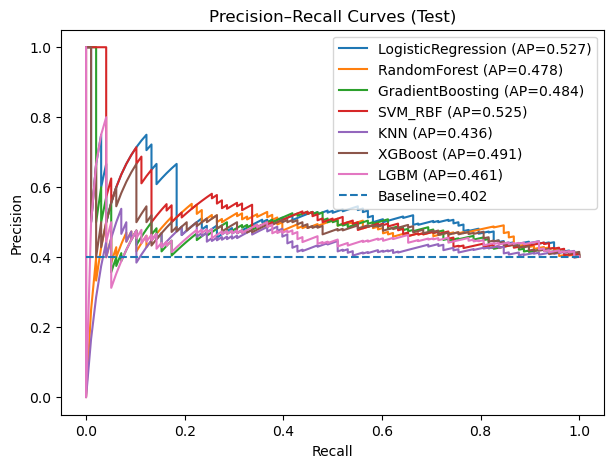


=== LogisticRegression — Feature Importance (Top 20) ===


,feature,importance,coef_signed
0,num__num_credit_cards,0.345600,0.345600
1,num__birth_year,0.108277,-0.108277
2,num__current_age,0.101302,0.101302
3,cat__most_prefer_Swipe,0.097480,0.097480
4,cat__most_prefer_Chip,0.091942,-0.091942
5,num__M_avg_max_amount,0.076686,0.076686
6,num__M_avg_median_amount,0.071408,-0.071408
7,num__credit_score,0.061346,-0.061346
8,cat__least_prefer_Chip,0.055032,-0.055032
9,num__per_capita_income,0.052999,-0.052999


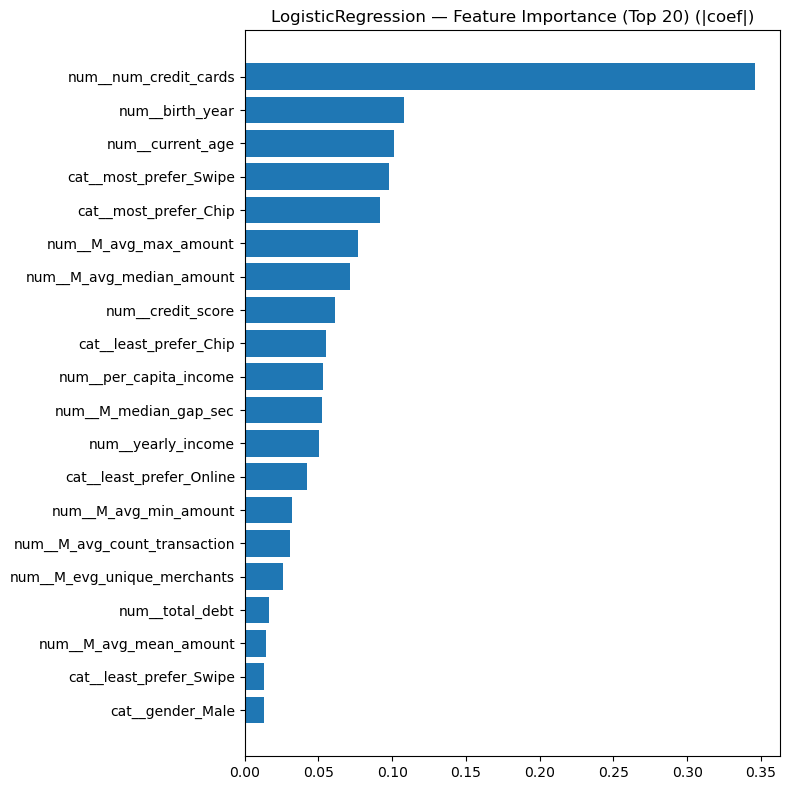


=== RandomForest — Feature Importance (Top 20) ===


,feature,importance
0,num__num_credit_cards,0.105126
1,num__M_evg_unique_merchants,0.085444
2,num__birth_year,0.064512
3,num__M_avg_max_amount,0.063177
4,num__M_avg_median_amount,0.061366
5,num__total_debt,0.053646
6,num__credit_score,0.053521
7,num__chip_ratio,0.052996
8,num__M_median_gap_sec,0.051407
9,num__M_avg_count_transaction,0.050262


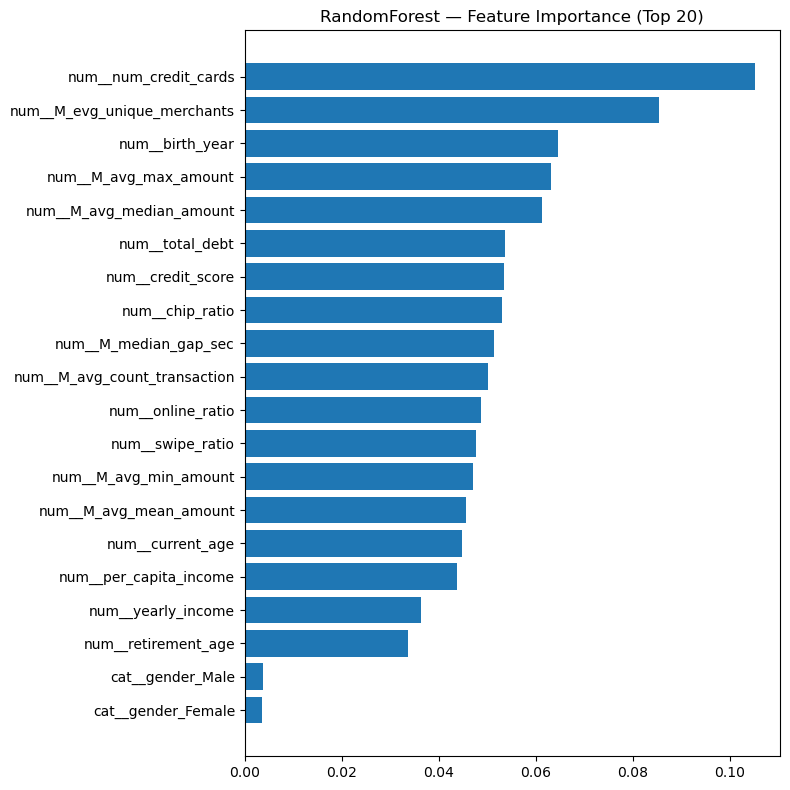


=== GradientBoosting — Feature Importance (Top 20) ===


,feature,importance
0,num__num_credit_cards,0.178082
1,num__M_evg_unique_merchants,0.103274
2,num__birth_year,0.067245
3,num__M_avg_count_transaction,0.064705
4,num__per_capita_income,0.060864
5,num__M_avg_max_amount,0.053663
6,num__current_age,0.049847
7,num__M_avg_median_amount,0.048292
8,num__online_ratio,0.046404
9,num__credit_score,0.045916


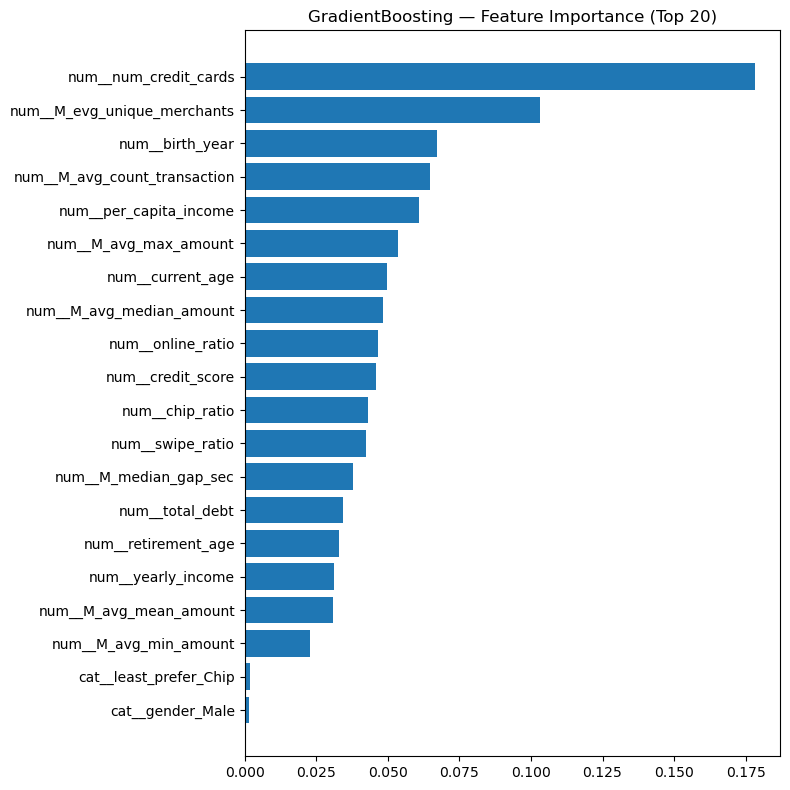


=== SVM_RBF — Feature Importance (Top 20) ===


,feature,importance
0,num__chip_ratio,0.119565
1,num__online_ratio,0.012883
2,cat__most_prefer_Chip,0.006744
3,num__per_capita_income,0.005864
4,num__retirement_age,0.003506
5,num__swipe_ratio,0.003065
6,cat__gender_Female,0.002920
7,num__M_median_gap_sec,0.002733
8,num__M_avg_min_amount,0.001938
9,num__yearly_income,0.000982


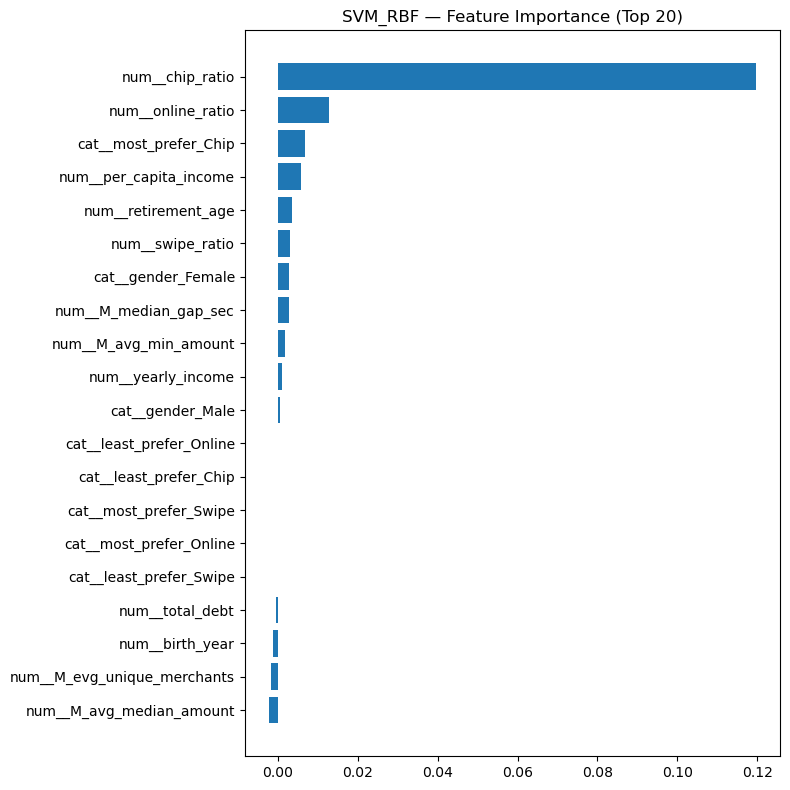


=== KNN — Feature Importance (Top 20) ===


,feature,importance
0,num__chip_ratio,0.018556
1,cat__most_prefer_Chip,0.007028
2,num__online_ratio,0.004478
3,cat__least_prefer_Swipe,0.000000
4,cat__least_prefer_Online,0.000000
5,cat__least_prefer_Chip,0.000000
6,cat__most_prefer_Swipe,0.000000
7,cat__most_prefer_Online,0.000000
8,num__per_capita_income,-0.000274
9,num__total_debt,-0.002338


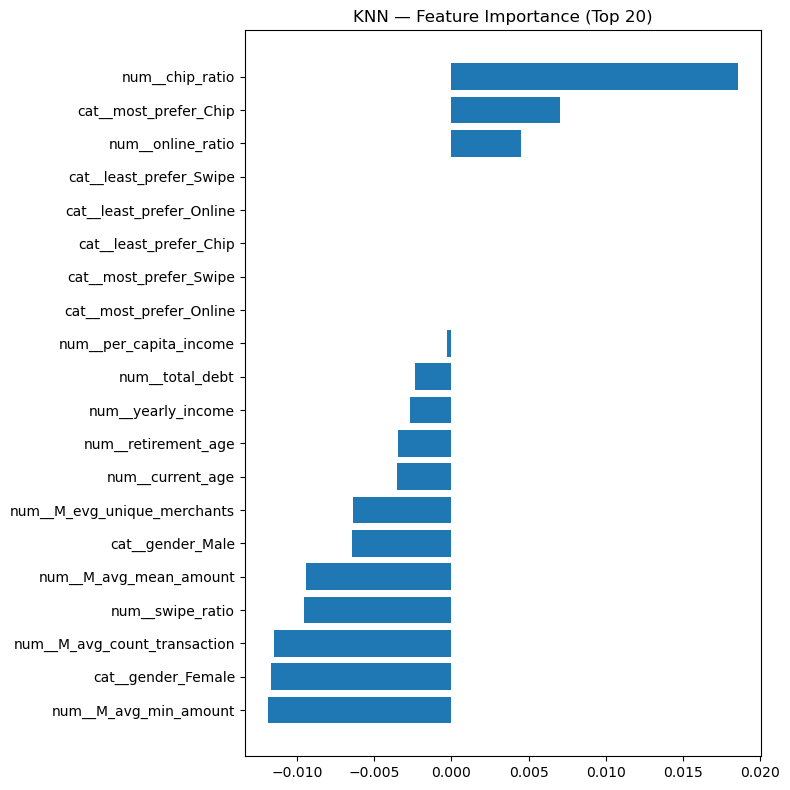


=== XGBoost — Feature Importance (Top 20) ===


,feature,importance
0,num__num_credit_cards,0.064919
1,num__current_age,0.056549
2,num__birth_year,0.055109
3,cat__most_prefer_Swipe,0.051658
4,num__M_evg_unique_merchants,0.045905
5,num__M_avg_max_amount,0.044932
6,cat__most_prefer_Chip,0.043350
7,num__chip_ratio,0.042986
8,cat__gender_Male,0.042681
9,num__yearly_income,0.041505


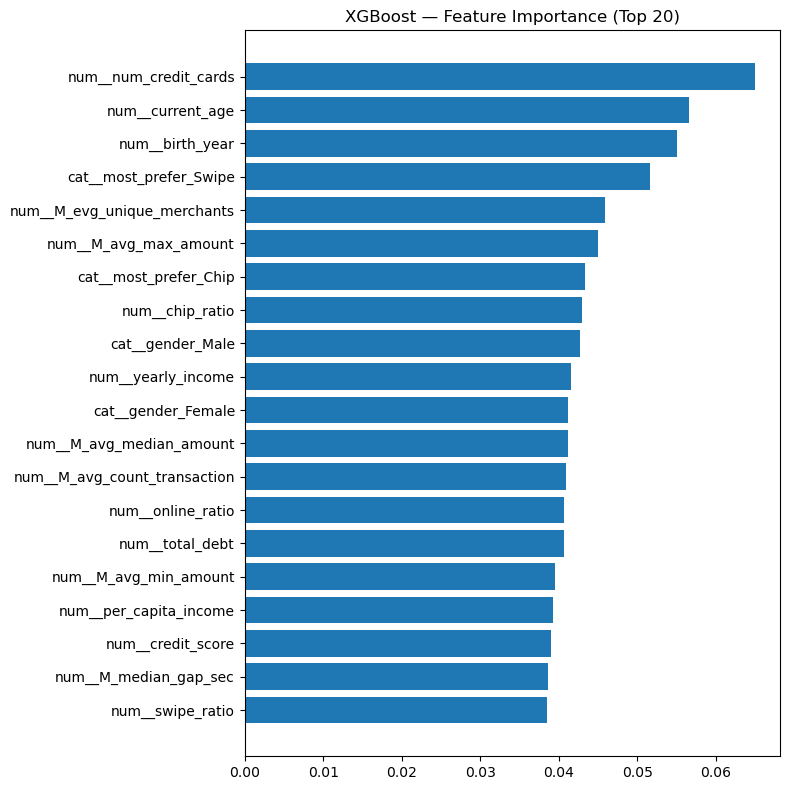


=== LGBM — Feature Importance (Top 20) ===


,feature,importance
0,num__M_evg_unique_merchants,3368.0
1,num__credit_score,3333.0
2,num__chip_ratio,3169.0
3,num__M_avg_min_amount,3099.0
4,num__total_debt,2917.0
5,num__online_ratio,2882.0
6,num__M_avg_median_amount,2820.0
7,num__M_median_gap_sec,2772.0
8,num__M_avg_max_amount,2770.0
9,num__swipe_ratio,2724.0


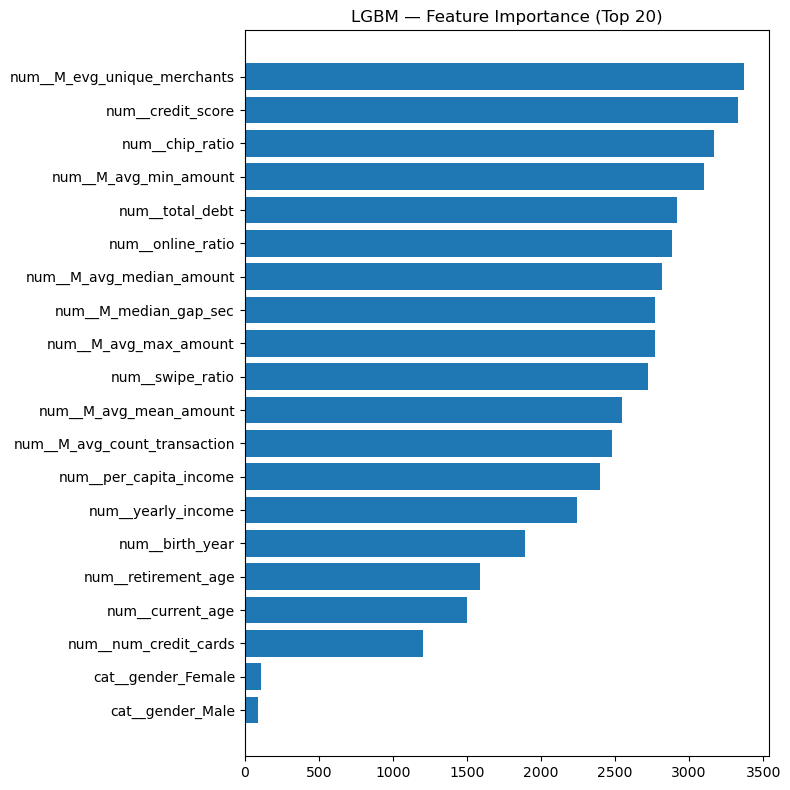

In [13]:
best_pipes, test_probas, rows = {}, {}, []

for name, (est, param_dists, n_iter) in models.items():
    pipe = Pipeline([("prep", preprocess), ("clf", est)])
    rs = RandomizedSearchCV(pipe, param_distributions=param_dists, n_iter=n_iter,
                            scoring="average_precision", cv=cv, n_jobs=-1, verbose=1,
                            refit=True, random_state=42)
    rs.fit(X_train, y_train)
    best = rs.best_estimator_
    best_pipes[name] = best

    y_pred = best.predict(X_test)
    if hasattr(best, "predict_proba"):
        proba = best.predict_proba(X_test)[:, 1]
    elif hasattr(best, "decision_function"):
        z = best.decision_function(X_test); proba = (z - z.min())/(z.max()-z.min() + 1e-9)
    else:
        proba = None
    test_probas[name] = proba

    row = {"model": name,
           "best_params": rs.best_params_,
           "cv_AP": rs.best_score_,
           "test_acc": accuracy_score(y_test, y_pred),
           "test_prec": precision_score(y_test, y_pred, zero_division=0),
           "test_rec": recall_score(y_test, y_pred, zero_division=0),
           "test_f1@0.5": f1_score(y_test, y_pred, zero_division=0),
           "test_ROC_AUC": np.nan if proba is None else roc_auc_score(y_test, proba),
           "test_PR_AUC":  np.nan if proba is None else average_precision_score(y_test, proba)}
    rows.append(row)

summary = pd.DataFrame(rows).sort_values(["test_PR_AUC","cv_AP"], ascending=[False, False]).reset_index(drop=True)
display(summary)

# ROC/PR 곡선 (확률 있는 모델만)
have_proba = {k:v for k,v in test_probas.items() if v is not None}
if have_proba:
    plt.figure(figsize=(7,5))
    for name, proba in have_proba.items():
        fpr, tpr, _ = roc_curve(y_test, proba)
        auc = roc_auc_score(y_test, proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1], "--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Test)"); plt.legend(); plt.show()

    plt.figure(figsize=(7,5))
    base = float(np.mean(y_test))
    for name, proba in have_proba.items():
        p, r, _ = precision_recall_curve(y_test, proba)
        ap = average_precision_score(y_test, proba)
        plt.plot(r, p, label=f"{name} (AP={ap:.3f})")
    plt.hlines(base, 0, 1, linestyles="--", label=f"Baseline={base:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision–Recall Curves (Test)"); plt.legend(); plt.show()

# 피처 중요도(Top 20) — 트리계열/로지스틱만 간단 표시
for name, pipe in best_pipes.items():
    clf = pipe.named_steps["clf"]
    prep = pipe.named_steps["prep"]
    try:
        feat_names = prep.get_feature_names_out(X_train.columns)
    except Exception:
        try:
            n_after = prep.transform(X_train.iloc[:5]).shape[1]
        except Exception:
            n_after = getattr(clf, "n_features_in_", len(X_train.columns))
        feat_names = np.array([f"f{i}" for i in range(n_after)], dtype=object)

    imp_df = None
    if hasattr(clf, "feature_importances_"):
        vals = np.asarray(clf.feature_importances_, float)
        if len(vals) != len(feat_names):
            if len(vals) < len(feat_names):
                vals = np.pad(vals, (0, len(feat_names)-len(vals)))
            else:
                vals = vals[:len(feat_names)]
        imp_df = pd.DataFrame({"feature": feat_names, "importance": vals})

    elif hasattr(clf, "coef_"):
        coefs = np.ravel(clf.coef_)
        if len(coefs) != len(feat_names):
            if len(coefs) < len(feat_names):
                coefs = np.pad(coefs, (0, len(feat_names)-len(coefs)))
            else:
                coefs = coefs[:len(feat_names)]
        imp_df = pd.DataFrame({"feature": feat_names,
                               "importance": np.abs(coefs),
                               "coef_signed": coefs})

    else:
        r = permutation_importance(pipe, X_test, y_test, scoring="average_precision",
                                   n_repeats=5, random_state=42, n_jobs=-1)
        vals = r.importances_mean
        if len(vals) != len(feat_names):
            if len(vals) < len(feat_names):
                vals = np.pad(vals, (0, len(feat_names)-len(vals)))
            else:
                vals = vals[:len(feat_names)]
        imp_df = pd.DataFrame({"feature": feat_names, "importance": vals})

    if imp_df is None:
        print(f"\n[{name}] 중요도 지원 안 함(또는 생략).")
        continue

    top = (imp_df.sort_values("importance", ascending=False).head(20)).reset_index(drop=True)
    print(f"\n=== {name} — Feature Importance (Top 20) ===")
    display(top)

    # 수평 바차트
    plt.figure(figsize=(8, max(4, 0.4*len(top))))
    plt.barh(top.iloc[::-1]["feature"], top.iloc[::-1]["importance"])
    ttl = f"{name} — Feature Importance (Top 20)"
    if hasattr(clf, "coef_"): ttl += " (|coef|)"
    plt.title(ttl)
    plt.tight_layout(); plt.show()

---

### Bagging + OOB 

In [14]:
from sklearn.ensemble import BaggingClassifier

# 현재 X의 컬럼 순서를 기준으로 인덱스 맵 만들기
col_order = list(X.columns)
idx_num = [col_order.index(c) for c in num_cols]
idx_cat = [col_order.index(c) for c in cat_cols]

# 트리/배깅용: 스케일링 없이 숫자는 통과, 범주 원-핫
prep_tree = ColumnTransformer([("cat", OneHotEncoder(handle_unknown="ignore", sparse=True), idx_cat),
                               ("num", "passthrough", idx_num)], remainder="drop")

# 선형/메타용: 숫자 스케일링 + 범주 원-핫
prep_lin = ColumnTransformer([("cat", OneHotEncoder(handle_unknown="ignore", sparse=True), idx_cat), 
                              ("num", StandardScaler(), idx_num)], remainder="drop")

In [15]:
base_est = Pipeline([("prep", prep_tree),
                     ("clf", LGBMClassifier(objective="binary", n_estimators=500, num_leaves=100, learning_rate=0.05, 
                                            subsample=0.8, colsample_bytree=0.8, min_child_samples=50, reg_lambda=1.0,
                                            class_weight="balanced", random_state=42, n_jobs=-1))])

bag = BaggingClassifier(estimator=base_est, n_estimators=30, max_samples=0.8, bootstrap=True, 
                        oob_score=True, n_jobs=-1, random_state=42)

bag.fit(X, y)

BaggingClassifier(estimator=Pipeline(steps=[('prep',
                                             ColumnTransformer(transformers=[('cat',
                                                                              OneHotEncoder(handle_unknown='ignore',
                                                                                            sparse=True),
                                                                              [3,
                                                                               12,
                                                                               13]),
                                                                             ('num',
                                                                              'passthrough',
                                                                              [18,
                                                                               15,
                                                                               16,
                                                                               17,
                                                                               14,
                                                                               19,
                                                                               20,
                                                                               2,
                                                                               9,
                                                                               7,
                                                                               0,
                                                                               8,
                                                                               10,
                                                                               4,
                                                                               1,
                                                                               11,
                                                                               6,
                                                                               5])])),
                                            ('clf',
                                             LGBMClassifier(class_weight='balanced',
                                                            colsample_bytree=0.8,
                                                            learning_rate=0.05,
                                                            min_child_samples=50,
                                                            n_estimators=500,
                                                            num_leaves=100,
                                                            objective='binary',
                                                            random_state=42,
                                                            reg_lambda=1.0,
                                                            subsample=0.8))]),
                  max_samples=0.8, n_estimators=30, n_jobs=-1, oob_score=True,
                  random_state=42)

In [16]:
def tune_threshold(y_true, proba, metric="f1"):
    grid = np.linspace(0.05, 0.95, 181)
    best_t, best = 0.5, -1
    for t in grid:
        pred = (proba >= t).astype(int)
        val = f1_score(y_true, pred) if metric=="f1" else None
        if val is not None and val > best:
            best, best_t = val, t
    return best_t, best

In [17]:
oob_df = bag.oob_decision_function_
oob_proba = oob_df[:, 1] if oob_df.ndim == 2 and oob_df.shape[1] == 2 else oob_df.ravel()
y_pred = (oob_proba >= 0.5).astype(int)

# (1) 임계값 0.5
y_pred_05 = (oob_proba >= 0.5).astype(int)
print("=== OOB classification_report @ threshold = 0.50 ===")
print(classification_report(y, y_pred_05, digits=4))

# (2) OOB에서 F1 기준 최적 임계값
thr_best, f1_best = tune_threshold(y, oob_proba, metric="f1")
y_pred_best = (oob_proba >= thr_best).astype(int)
print(f"\n=== OOB classification_report @ best F1 threshold = {thr_best:.3f} ===")
print(classification_report(y, y_pred_best, digits=4))

=== OOB classification_report @ threshold = 0.50 ===
              precision    recall  f1-score   support

         0.0     0.6620    0.7202    0.6899       729
         1.0     0.5211    0.4531    0.4847       490

    accuracy                         0.6128      1219
   macro avg     0.5916    0.5866    0.5873      1219
weighted avg     0.6054    0.6128    0.6074      1219


=== OOB classification_report @ best F1 threshold = 0.240 ===
              precision    recall  f1-score   support

         0.0     0.7520    0.3827    0.5073       729
         1.0     0.4693    0.8122    0.5949       490

    accuracy                         0.5554      1219
   macro avg     0.6107    0.5975    0.5511      1219
weighted avg     0.6384    0.5554    0.5425      1219



In [18]:
from sklearn.metrics import  (roc_auc_score, average_precision_score, f1_score, accuracy_score,
    precision_score, recall_score, classification_report, roc_curve, precision_recall_curve, confusion_matrix)


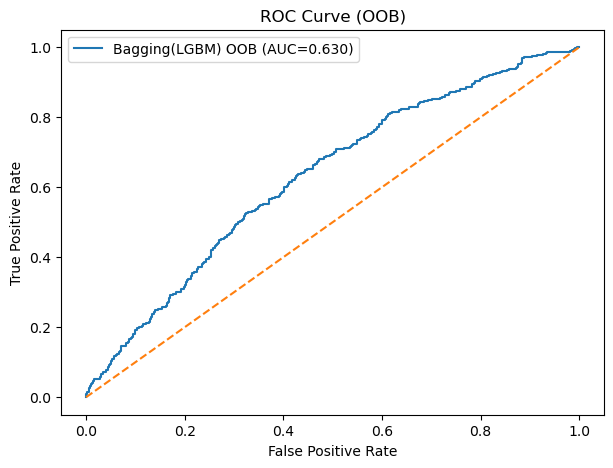

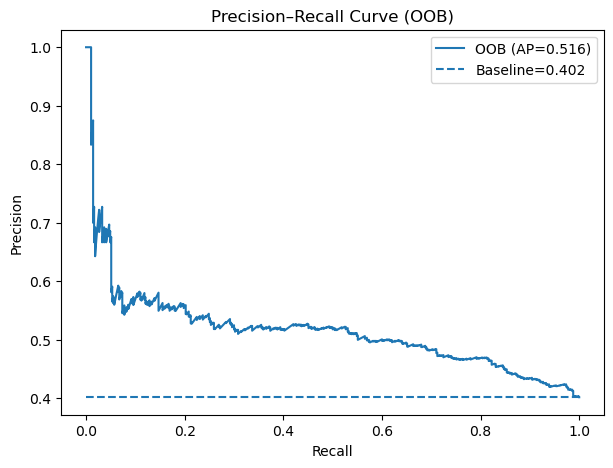

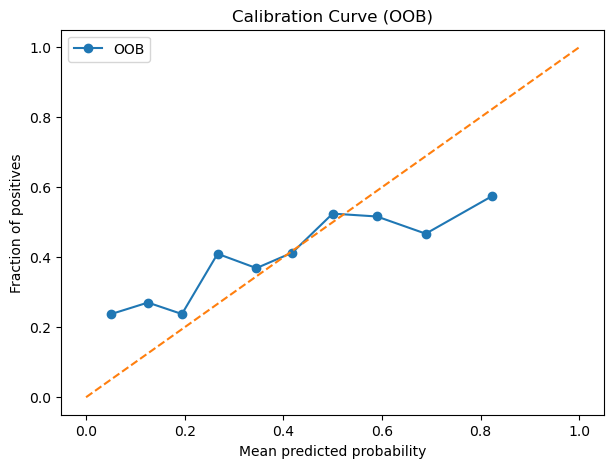

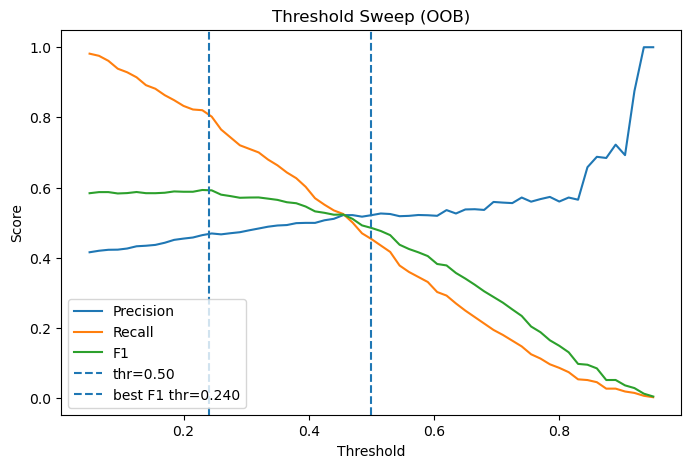

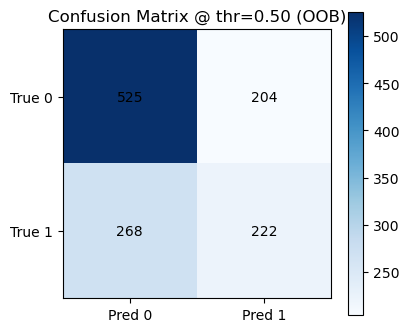

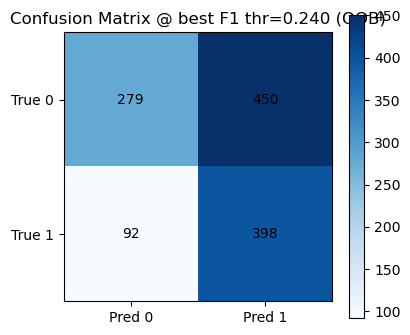

Top1% Precision : 0.6667  | Recall : 0.0163
Top3% Precision : 0.6667  | Recall : 0.049
Top5% Precision : 0.5833  | Recall : 0.0714


In [19]:
def precision_at_k(y_true, proba, k=0.03):
    y_true = np.asarray(y_true).reshape(-1)
    n = max(1, int(len(proba)*k))
    idx = np.argsort(-proba)[:n]
    return (y_true[idx] == 1).mean()

def recall_at_k(y_true, proba, k=0.03):
    y_true = np.asarray(y_true).reshape(-1)
    n = max(1, int(len(proba)*k))
    idx = np.argsort(-proba)[:n]
    return y_true[idx].sum() / y_true.sum()

# ROC Curve
plt.figure(figsize=(7,5))
fpr, tpr, _ = roc_curve(y, oob_proba)
auc = roc_auc_score(y, oob_proba)
plt.plot(fpr, tpr, label=f"Bagging(LGBM) OOB (AUC={auc:.3f})")
plt.plot([0,1],[0,1], "--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve (OOB)")
plt.legend(); plt.show()

# PR Curve
plt.figure(figsize=(7,5))
prec, rec, _ = precision_recall_curve(y, oob_proba)
ap = average_precision_score(y, oob_proba)
baseline = float(np.mean(y))
plt.plot(rec, prec, label=f"OOB (AP={ap:.3f})")
plt.hlines(baseline, 0, 1, linestyles="--", label=f"Baseline={baseline:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve (OOB)")
plt.legend(); plt.show()

# Calibration Curve (분위수 10 bins)
def calibration_curve_quantile(y_true, proba, n_bins=10):
    qs = np.linspace(0,1,n_bins+1)
    edges = np.quantile(proba, qs)
    edges = np.unique(edges)
    bins = np.digitize(proba, edges[1:-1], right=True)
    mean_pred = []
    frac_pos = []
    for b in range(bins.min(), bins.max()+1):
        mask = (bins == b)
        if mask.sum() == 0: 
            continue
        mean_pred.append(proba[mask].mean())
        frac_pos.append(y[mask].mean())
    return np.array(mean_pred), np.array(frac_pos)

mp, fp = calibration_curve_quantile(np.asarray(y), oob_proba, n_bins=10)
plt.figure(figsize=(7,5))
plt.plot(mp, fp, marker="o", label="OOB")
plt.plot([0,1],[0,1], "--")
plt.xlabel("Mean predicted probability"); plt.ylabel("Fraction of positives")
plt.title("Calibration Curve (OOB)")
plt.legend(); plt.show()

# 임계값 스윕(Precision/Recall/F1)
ths = np.linspace(0.05, 0.95, 61)
P, R, F = [], [], []
y_arr = np.asarray(y).reshape(-1)
for t in ths:
    yp = (oob_proba >= t).astype(int)
    tp = ((yp==1)&(y_arr==1)).sum()
    fp_ = ((yp==1)&(y_arr==0)).sum()
    fn = ((yp==0)&(y_arr==1)).sum()
    p = tp / (tp+fp_ + 1e-9)
    r = tp / (tp+fn + 1e-9)
    f1 = 2*p*r / (p+r + 1e-9)
    P.append(p); R.append(r); F.append(f1)

plt.figure(figsize=(8,5))
plt.plot(ths, P, label="Precision")
plt.plot(ths, R, label="Recall")
plt.plot(ths, F, label="F1")
plt.axvline(0.5, ls="--", label="thr=0.50")
plt.axvline(thr_best, ls="--", label=f"best F1 thr={thr_best:.3f}")
plt.xlabel("Threshold"); plt.ylabel("Score")
plt.title("Threshold Sweep (OOB)")
plt.legend(); plt.show()

# Confusion Matrix (thr=0.50 vs best F1 thr)
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4.2,3.6))
    plt.imshow(cm, cmap="Blues")
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i,j], ha="center", va="center")
    plt.xticks([0,1], ["Pred 0","Pred 1"])
    plt.yticks([0,1], ["True 0","True 1"])
    plt.title(title); plt.colorbar(); plt.tight_layout(); plt.show()

plot_cm(y, y_pred_05, "Confusion Matrix @ thr=0.50 (OOB)")
plot_cm(y, y_pred_best, f"Confusion Matrix @ best F1 thr={thr_best:.3f} (OOB)")

# 6) 운영지표: Precision@K & Recall@K (K=1%, 3%, 5%)
for k in [0.01, 0.03, 0.05]:
    print(f"Top{k*100:.0f}% Precision :", round(precision_at_k(y, oob_proba, k), 4),
          " | Recall :", round(recall_at_k(y, oob_proba, k), 4))